In [238]:
from math import radians, cos, sin, asin, sqrt
import os
from random import sample

import contextily as cx
import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import pickle
import shapely.geometry
from zipfile import ZipFile

In [237]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in meters between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r * 1000

In [195]:
def combine_all_folder_data(folder, n_sample=None):
    """
    Combine all the daily .pkl files containing feed data into a single dataframe.
    folder: the folder full of .pkl files to combine
    n_sample: the number of files to sample from the folder (all if false)
    Returns: a dataframe of all data concatenated together, a column 'file' is added
    """
    data_list = []
    if n_sample is not None:
        files = sample(os.listdir(folder), n_sample)
    else:
        files = os.listdir(folder)
    for file in files:
        if file != ".DS_Store":
            with open(folder+'/'+file, 'rb') as f:
                data = pickle.load(f)
                data['file'] = file
                data_list.append(data)
    data = pd.concat(data_list, axis=0)
    return data

In [284]:
def calculate_trace_df(data, file_col, tripid_col, locid_col, lat_col, lon_col, diff_cols, use_coord_dist=False):
    """
    Calculate difference in metrics between two consecutive trip points.
    data: pandas df with all bus trips
    file_col: column name that separates each pkl file
    tripid_col: column name that has unique trip ids
    locid_col: column name that has the time of the observation
    lat_col: column name with latitude
    lon_col: column name with longitude
    diff_cols: list of column names to calculate metrics across
    use_coord_dist: whether or not to calculate lat/lon distances vs odometer
    Returns: combination of original point values, and new _diff values
    """
    # Get in order by locationtime
    df = data.sort_values([file_col, tripid_col, locid_col], ascending=True)
    # Calculate differences between consecutive locations
    diff = df.groupby([file_col, tripid_col])[diff_cols].diff()
    diff.columns = [colname+'_diff' for colname in diff.columns]
    traces = pd.concat([df, diff], axis=1)
    if use_coord_dist:
        shift = df.groupby([file_col, tripid_col]).shift()
        hav = pd.concat([df[[lat_col,lon_col]], shift[[lat_col,lon_col]]], axis=1)
        hav.columns = ["lat1","lon1","lat2","lon2"]
        traces['dist_calc'] = hav.apply(lambda x: haversine(x.lon1, x.lat1, x.lon2, x.lat2), axis=1)
    traces.dropna(inplace=True)
    return traces

In [315]:
data = combine_all_folder_data("../data/kcm_validation")

,tripid,vehicleid,lat,lon,orientation,scheduledeviation,totaltripdistance,tripdistance,closeststop,nextstop,locationtime,collectedtime,file
0,347458201.0,7424.0,47.602687,-122.184991,203.0,-248.0,35337.402543,118.045828,70812.0,70812.0,1.662595e+09,1.662595e+09,2022_09_07.pkl
1,347458201.0,7424.0,47.602687,-122.184991,203.0,-208.0,35337.402543,118.045828,70812.0,70812.0,1.662595e+09,1.662595e+09,2022_09_07.pkl
2,347458201.0,7424.0,47.602687,-122.184991,203.0,-188.0,35337.402543,118.045828,70812.0,70812.0,1.662595e+09,1.662595e+09,2022_09_07.pkl
3,347458201.0,7424.0,47.602687,-122.184991,203.0,-148.0,35337.402543,118.045828,70812.0,70812.0,1.662595e+09,1.662595e+09,2022_09_07.pkl
4,347458201.0,7424.0,47.602664,-122.185044,203.0,-108.0,35337.402543,122.767661,70812.0,70812.0,1.662595e+09,1.662595e+09,2022_09_07.pkl
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115049,587768812.0,7485.0,47.290368,-122.216042,270.0,638.0,6940.862706,2952.385597,58410.0,57631.0,1.663772e+09,1.663772e+09,2022_09_21.pkl
115050,587768812.0,7485.0,47.290054,-122.218741,180.0,638.0,6940.862706,3187.864445,57631.0,57631.0,1.663772e+09,1.663772e+09,2022_09_21.pkl
115051,587768812.0,7485.0,47.289369,-122.221405,270.0,624.0,6940.862706,3463.711185,57631.0,57632.0,1.663772e+09,1.663772e+09,2022_09_21.pkl
115052,587768812.0,7485.0,47.286101,-122.221382,270.0,610.0,6940.862706,3827.205554,57632.0,57640.0,1.663772e+09,1.663772e+09,2022_09_21.pkl


In [316]:
traces = calculate_trace_df(data, 'file', 'tripid', 'locationtime', 'lat', 'lon', ['orientation','scheduledeviation','tripdistance','locationtime'])

,tripid,vehicleid,lat,lon,orientation,scheduledeviation,totaltripdistance,tripdistance,closeststop,nextstop,locationtime,collectedtime,file,orientation_diff,scheduledeviation_diff,tripdistance_diff,locationtime_diff,speed_m_s
1,347458161.0,7421.0,47.755872,-122.155458,294.0,0.0,20172.267567,512.141257,78000.0,78000.0,1.662559e+09,1.662559e+09,2022_09_07.pkl,24.0,0.0,503.751811,60.0,8.395864
2,347458161.0,7421.0,47.754482,-122.157012,180.0,0.0,20172.267567,804.312167,76000.0,76000.0,1.662559e+09,1.662559e+09,2022_09_07.pkl,-114.0,0.0,292.170910,35.0,8.347740
5,347458161.0,7421.0,47.754986,-122.155205,270.0,121.0,20172.267567,613.170059,78000.0,78000.0,1.662559e+09,1.662559e+09,2022_09_07.pkl,90.0,0.0,453.770592,54.0,8.403159
6,347458161.0,7421.0,47.754482,-122.155345,180.0,121.0,20172.267567,679.654270,78000.0,76000.0,1.662559e+09,1.662559e+09,2022_09_07.pkl,-90.0,0.0,66.484212,8.0,8.310526
7,347458161.0,7421.0,47.754482,-122.158791,180.0,110.0,20172.267567,937.280590,76000.0,76000.0,1.662559e+09,1.662559e+09,2022_09_07.pkl,0.0,-11.0,257.626320,37.0,6.962874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273479,589919432.0,7234.0,47.784676,-122.298828,180.0,18.0,14144.174147,13038.784477,1695.0,1696.0,1.668272e+09,1.668272e+09,2022_11_12.pkl,0.0,10.0,89.681765,22.0,4.076444
273480,589919432.0,7234.0,47.784722,-122.303917,180.0,-10.0,14144.174147,13419.028095,1697.0,1698.0,1.668272e+09,1.668272e+09,2022_11_12.pkl,0.0,-28.0,380.243618,21.0,18.106839
273481,589919432.0,7234.0,47.784784,-122.308344,179.0,-25.0,14144.174147,13749.825384,1699.0,1699.0,1.668272e+09,1.668272e+09,2022_11_12.pkl,-1.0,-15.0,330.797289,32.0,10.337415
273482,589919432.0,7234.0,47.784813,-122.310631,179.0,-13.0,14144.174147,13920.729743,1699.0,85250.0,1.668272e+09,1.668272e+09,2022_11_12.pkl,0.0,12.0,170.904358,35.0,4.882982


In [ ]:
# Calculate and remove speeds that are unreasonable
traces['speed_m_s'] = traces['tripdistance_diff'] / traces['locationtime_diff']
traces = traces.loc[traces['speed_m_s']>0]
traces = traces.loc[traces['speed_m_s']<35]
traces

In [317]:
# Extract zip files of all validation tracks in folder
folder = "../data/kcm_validation_sensor/"
for file in os.listdir(folder):
    if file != ".DS_Store" and file[-4] == ".":
        with ZipFile(folder+file, 'r') as zip:
            zip.extractall(folder+file[:-4])

# Combine all validation data into a dict, filenames are the keys
folder = "../data/kcm_validation_sensor/"
validation_data_lookup = {}
for file in os.listdir(folder):
    if file != ".DS_Store" and file[-4:] != ".zip":
        df = [pd.read_csv(folder+file+"/"+validation_file) for validation_file in os.listdir(folder+file)]
        validation_data_lookup[file] = df

# Show available keys
validation_data_lookup.keys()

dict_keys(['8154-link_shuttle-2022-11-12_18-01-32', '4527-49-2022-09-07_05-25-03', '6993-255-2022-11-05_16-43-43', '6210-dline-2022-09-30_00-25-43', '7145-31-2022-09-07_05-04-12', '4520-43-2022-09-12_02-36-21', '8297-21-2022-09-21_22-05-21', '8140-8-2022-10-17_22-21-45', '8117-8-2022-09-30_00-45-56', '8206-21-2022-09-21_00-17-03', '8072-8-2022-10-21_02-41-31', '4531-43-2022-11-04_06-43-08', '8042-8-2022-09-30_23-12-19', '8043-24-2022-09-30_23-31-00', '8027-62-2022-09-07_01-29-34', '8050-8-2022-09-07_01-15-33', '8124-33-2022-10-17_20-52-26', '8072-8-2022-10-21_05-33-29', '6113-49-2022-09-25_16-58-00'])

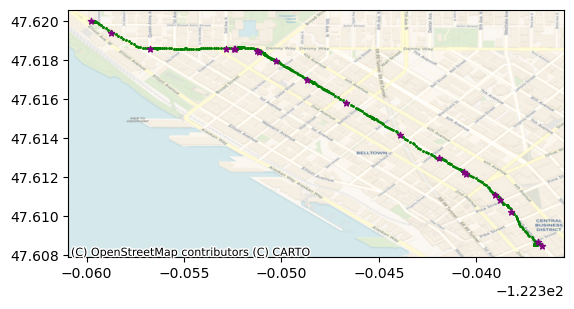

In [339]:
# Plot original route traces + validation traces

# Get traces from a single validation trip
validation_trip = "8124-33-2022-10-17_20-52-26"
validation_traces = validation_data_lookup[validation_trip][2]
validation_traces = geopandas.GeoDataFrame(validation_traces, geometry=geopandas.points_from_xy(validation_traces.longitude, validation_traces.latitude), crs="EPSG:4326")
# Use less digits in the epoch time
validation_traces['time'] = [int(str(x)[:10]) for x in validation_traces['time']]

# Get corresponding GTFS-RT trip traces (if recorded)
trip_details = validation_trip.split("-")
vehicle_id = trip_details[0]
original_traces = traces[traces['vehicleid']==float(vehicle_id)]
original_traces = original_traces[original_traces['locationtime']>=min(validation_traces['time'])]
original_traces = original_traces[original_traces['locationtime']<=max(validation_traces['time'])]
original_traces = geopandas.GeoDataFrame(original_traces, geometry=geopandas.points_from_xy(original_traces.lon, original_traces.lat), crs="EPSG:4326")

# Map trip to shape id
gtfs_trips = pd.read_csv("../data/kcm_gtfs/trips.txt")
gtfs_trips.head()

# If the original traces were found in the GTFS-RT, plot them
fig, ax = plt.subplots(1,1)
if (len(original_traces)) == 0:
    print("Validation trip was not captured in the GTFS-RT.")
else:
    validation_traces.plot(ax=ax, marker='.', color='green', markersize=5)
    original_traces.plot(ax=ax, marker='*', color='purple', markersize=20)
    cx.add_basemap(ax, crs=original_traces.crs, source=cx.providers.CartoDB.Voyager)
    plt.savefig("../plots/original_validation.png", dpi=1800, bbox_inches='tight')

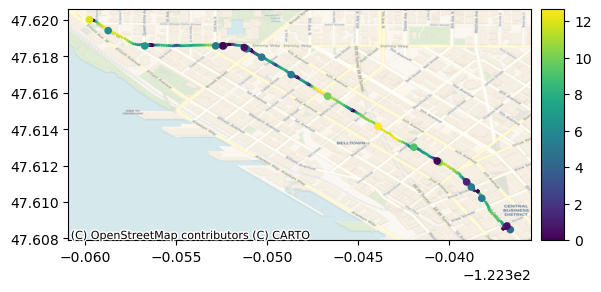

In [340]:
# Make plot showing speeds
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
validation_traces.plot(ax=ax, cax=cax, marker='.', column='speed', markersize=5, legend=True)
original_traces.plot(ax=ax, marker='o', column='speed_m_s', markersize=20)
cx.add_basemap(ax, crs=original_traces.crs, source=cx.providers.CartoDB.Voyager)
plt.savefig("../plots/original_validation_speed.png", dpi=1800, bbox_inches='tight')

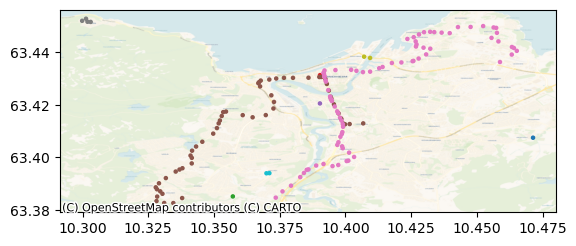

In [341]:
# Plot a sample of the Norway routes
data = combine_all_folder_data("../data/nwy_all", n_sample=2)
data['locationtime'] = data['locationtime'].astype(int)
data['lat'] = data['lat'].astype(float)
data['lon'] = data['lon'].astype(float)
data['bearing'] = data['bearing'].astype(float)
traces = calculate_trace_df(data, 'file', 'datedvehiclejourney', 'locationtime', 'lat', 'lon', ['bearing','locationtime'], use_coord_dist=True)

# Calculate speed, filter all unreasonable speeds
traces['speed_m_s'] = traces['dist_calc'] / traces['locationtime_diff']
traces = traces.loc[traces['speed_m_s']>0]
traces = traces.loc[traces['speed_m_s']<35]

# Select some random trips from AtB
traces_sample = traces.loc[traces['datasource']=='ATB']
traces_sample = geopandas.GeoDataFrame(traces_sample, geometry=geopandas.points_from_xy(traces_sample.lon, traces_sample.lat), crs="EPSG:4326")
traces_sample = traces_sample.cx[10.298103:10.513709, 63.370637:63.463433]
trips = sample(list(pd.unique(traces_sample['datedvehiclejourney'])), 10)
traces_sample = traces_sample.loc[traces_sample['datedvehiclejourney'].isin(trips)]

# Plot them
# original_traces = geopandas.GeoDataFrame(traces_sample, geometry=geopandas.points_from_xy(traces_sample.lon, traces_sample.lat), crs="EPSG:4326")
fig, ax = plt.subplots(1,1)
traces_sample.plot(ax=ax, marker='.', column='datedvehiclejourney', markersize=20)
cx.add_basemap(ax, crs=original_traces.crs, source=cx.providers.CartoDB.Voyager)
plt.savefig("../plots/nwy_sample.png", dpi=1800, bbox_inches='tight')

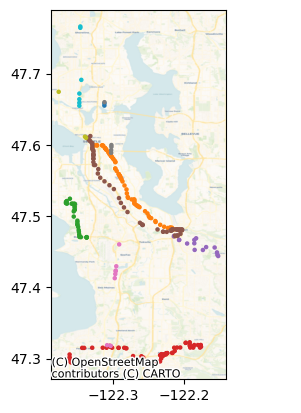

In [342]:
# Plot a sample of the KCM routes
data = combine_all_folder_data("../data/kcm_all", n_sample=2)
data['locationtime'] = data['locationtime'].astype(int)
data['lat'] = data['lat'].astype(float)
data['lon'] = data['lon'].astype(float)
data['tripid'] = data['tripid'].astype(str)
traces = calculate_trace_df(data, 'file', 'tripid', 'locationtime', 'lat', 'lon', ['orientation','locationtime', 'tripdistance'])

# Calculate speed, filter all unreasonable speeds
traces['speed_m_s'] = traces['tripdistance_diff'] / traces['locationtime_diff']
traces = traces.loc[traces['speed_m_s']>0]
traces = traces.loc[traces['speed_m_s']<35]

# Select some random trips
traces_sample = geopandas.GeoDataFrame(traces, geometry=geopandas.points_from_xy(traces.lon, traces.lat), crs="EPSG:4326")
trips = sample(list(pd.unique(traces_sample['tripid'])), 10)
traces_sample = traces_sample.loc[traces_sample['tripid'].isin(trips)]

# Plot them
# original_traces = geopandas.GeoDataFrame(traces_sample, geometry=geopandas.points_from_xy(traces_sample.lon, traces_sample.lat), crs="EPSG:4326")
fig, ax = plt.subplots(1,1)
traces_sample.plot(ax=ax, marker='.', column='tripid', markersize=20)
cx.add_basemap(ax, crs=original_traces.crs, source=cx.providers.CartoDB.Voyager)
plt.savefig("../plots/kcm_sample.png", dpi=1800, bbox_inches='tight')